# Convolutional Neural Networks

#### Exploring transfer learning for image recognition

## By Brea koenes

### Overview

The [`CIFAR10` dataset](https://keras.io/api/datasets/cifar10/) contains 50,000 32 $\times$ 32 colored images of the things listed below. 

| Label    | Description |
| -------- | -------|
| 0 | airplane    |
| 1 | automobile     |
| 2 | bird    |
| 3 | cat    |
| 4 | deer    |
| 5 | dog    |
| 6 | frog    |
| 7 | horse    |
| 8 | ship    |
| 9 | truck    |

The `base_model` contains a CNN that was trained on over 17,000 CIFAR10 images, none of which contained a horse, ship, or truck. I use the bottleneck layers of the `base_model`, along with transfer learning to build a network that can classify all 10 categories of the images in the CIFAR10 dataset.

### Imports

In [18]:
# Imports, ensure Tensorflow 2.9.2 is downloaded
import subprocess
import sys
from IPython.display import clear_output
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

### Data and Model Prep

Load the `base_model` and the data.

In [19]:
# Load base model
base_model = load_model('base_model3.h5')

In [20]:
# Load test and train data
x_train = np.loadtxt('data/x_train.txt').reshape(32516, 32, 32, 3)
y_train = np.loadtxt('data/y_train.txt')
x_test = np.loadtxt('data/x_test.txt').reshape(6512, 32, 32, 3)
y_test = np.loadtxt('data/y_test.txt')

Test the `base_model` to load and display a sample image of a ship from the test dataset. Use the `base_model` to make a prediction about the object contained in the sample image.

8.0


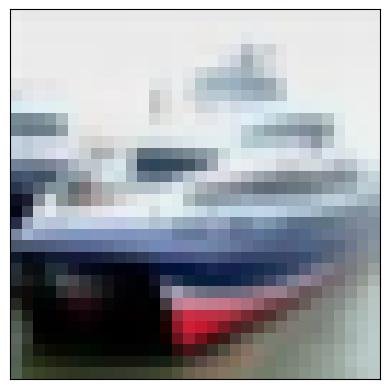

In [21]:
# Print image
%matplotlib inline
import matplotlib.pyplot as plt
x = x_test[0]

print(y_test[0])
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [22]:
from tensorflow.keras.preprocessing import image

# Preprocess the image
x = image.img_to_array(x_test[0])
x = np.expand_dims(x, axis=0)

# Make prediction about sample image
y = base_model.predict(x)
y

1/1 [==============================] - 0s 21ms/step


array([[1.0781821e-01, 8.9212835e-01, 4.9011473e-05, 3.9390557e-06,
        2.2663505e-07, 1.6919410e-07, 2.2266289e-09]], dtype=float32)

Use transfer learning to create a domain-specific model that can classify images of horses, ships, and trucks in addition to the rest of the images that the `base_model` was trained on.

In [23]:
from tensorflow.keras.models import Model

# Extract bottleneck layers from the `base_model`
model = Model(inputs = base_model.layers[0].input, outputs = base_model.layers[3].output)

### Transfer Learning

Create the classification layers for transfer learning and train them.

In [24]:
# Run all of the training images through the base model for feature extraction
x_train = model.predict(x_train)
x_test = model.predict(x_test)

204/204 [==============================] - 0s 2ms/step


In [25]:
# Create network of classification layers and run the features through the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.metrics import Recall

# Create classification layers
classification = Sequential()
classification.add(Flatten())
classification.add(Dense(256, activation='relu'))
classification.add(Dense(10, activation='softmax'))
classification.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Run the features through the classification layers
hist = classification.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

Epoch 1/10
3252/3252 [==============================] - 3s 986us/step - loss: 1.0813 - accuracy: 0.6211 - val_loss: 0.9728 - val_accuracy: 0.6625
Epoch 2/10
3252/3252 [==============================] - 4s 1ms/step - loss: 0.8208 - accuracy: 0.7136 - val_loss: 0.9021 - val_accuracy: 0.6906
Epoch 3/10
3252/3252 [==============================] - 3s 992us/step - loss: 0.6687 - accuracy: 0.7678 - val_loss: 0.8817 - val_accuracy: 0.6970
Epoch 4/10
3252/3252 [==============================] - 3s 1ms/step - loss: 0.5387 - accuracy: 0.8141 - val_loss: 0.8799 - val_accuracy: 0.7053
Epoch 5/10
3252/3252 [==============================] - 3s 891us/step - loss: 0.4273 - accuracy: 0.8499 - val_loss: 0.9471 - val_accuracy: 0.7047
Epoch 6/10
3252/3252 [==============================] - 3s 891us/step - loss: 0.3205 - accuracy: 0.8909 - val_loss: 1.0680 - val_accuracy: 0.7002
Epoch 7/10
3252/3252 [==============================] - 3s 826us/step - loss: 0.2424 - accuracy: 0.9187 - val_loss: 1.1218 - val

Plot the training and validation accuracy.

[]

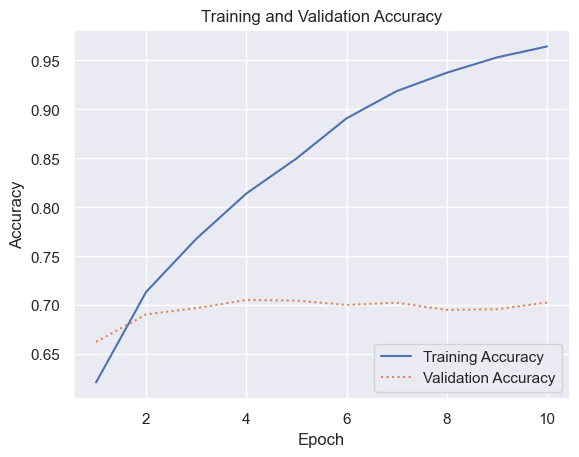

In [26]:
import seaborn as sns

sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Check to ensure the new model correctly classifies the sample image of a ship.

In [27]:
# Preprocess the image for prediction
x_sample = np.expand_dims(x_test[0], axis=0)  

# Pass the features through the classification layers
y_pred = classification.predict(x_sample)

# Get the predicted label
predicted_label = np.argmax(y_pred)
print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 14ms/step
Predicted Label: 8


### Export Models

Export Classification and CNN models

In [28]:
# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Export classification model
classification.save('classification_model.h5')

# Export CNN model
model.save('CNN_model.h5')